In [1]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table, join, Column

from astropy.io import ascii
import glob, re

% matplotlib inline

import matplotlib as mpl
mpl.style.use('seaborn-colorblind')

#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(12.0,9.0)    #(6.0,4.0)
mpl.rcParams['font.size']=18               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12


## This notebook reads in Keith's abundances and Guy's asteroseismology to produce the tables for the paper.

In [2]:
fname_diff = "../data/abundances/Pope_abundances_diff_arcturus.fits"
fname_nodiff = "../data/abundances/Pope_abundances_nodiff.fits"

In [3]:
diff = Table.read(fname_diff)
diff.sort('Object')
nodiff = Table.read(fname_nodiff)
nodiff.sort('Object')

How do abundances compare between the differential and non-differential methods? Not too badly. Many more elements lack differential abundances than absolute abundances so it looks like in the paper we shouldn't use the differential. Good to include in online data though.

In [4]:
# for j, key in enumerate(diff.keys()[1:]):
#     if key[0]=='e':
#         continue
#     plt.figure(j)
#     plt.plot(diff[key],nodiff[key],'.')
#     plt.title(key)

In [5]:
nodiff

Object,Ca_Fe,eCa_Fe,Mg_Fe,eMg_Fe,Si_Fe,eSi_Fe,Ti_Fe,eTi_Fe,O_Fe,eO_Fe,Al_Fe,eAl_Fe,Ba_Fe,eBa_Fe,Na_Fe,eNa_Fe,Ni_Fe,eNi_Fe,Mn_Fe,eMn_Fe,Co_Fe,eCo_Fe,Eu_Fe,eEu_Fe,La_Fe,eLa_Fe,Zr_Fe,eZr_Fe,Sr_Fe,eSr_Fe,Zn_Fe,eZn_Fe,Y_Fe,eY_Fe,Cr_Fe,eCr_Fe,V_Fe,eV_Fe,Cu_Fe,eCu_Fe,Sc_Fe,eSc_Fe
str10,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
BD+36_3564,0.20550000000000068,0.021811959427664313,0.32699999999999996,0.029981933288751386,0.1030000000000002,0.03033791174238739,0.3414999999999999,0.039563195412588896,nan,nan,0.39749999999999996,0.008838834764831969,nan,nan,0.2600000000000007,0.07726769244837267,0.006000000000000227,0.04284999081677555,0.07750000000000057,0.0045961940777125235,0.1299999999999999,0.023192941522005114,0.24799999999999933,0.02768573639981425,-0.016499999999999737,0.0659359300760974,0.10200000000000031,0.021922773547158676,0.3440000000000003,0.11825713509129157,-0.28699999999999903,0.19772933239377738,-0.2739999999999996,0.015773296262988193,0.23000000000000043,0.003797614382740828,0.1535000000000002,0.03049898435435564,-0.04499999999999971,0.06190150947270998,0.17300000000000093,0.017790381816734174
BD+39_3577,0.1330000000000009,0.024249415323230328,0.2150000000000003,0.03658925303282372,-0.10549999999999926,0.02174089847882709,0.08499999999999996,0.03879026485998592,nan,nan,0.20550000000000024,0.00954594154601844,0.3520000000000003,0.1010273157048059,0.41600000000000037,0.0,-0.051000000000000156,0.03328029088036782,-0.028999999999999027,0.05782989102787844,-0.015999999999999126,0.02072659732649556,-0.22100000000000009,0.04160228359116841,-0.254999999999999,0.015035759843588615,0.128000000000001,0.08221016968721083,nan,nan,-0.24099999999999877,0.7076482176901175,-0.4039999999999999,0.037289656991162025,0.1640000000000006,0.0952853444922145,0.010500000000000398,0.020276010901452025,-0.20599999999999952,0.012727922061357708,-0.12499999999999956,0.053405093390050375
BD+43_3064,0.18600000000000083,0.042992624259758146,0.2110000000000003,0.03401960219246152,-0.013999999999999346,0.030231207814540438,0.28249999999999975,0.044954827587674044,nan,nan,0.3550000000000004,0.010606601717797986,nan,nan,0.4790000000000001,0.06424951361683594,0.052999999999999936,0.044591812612475384,0.21400000000000086,0.024748737341528947,0.1330000000000009,0.02184520148655853,0.28000000000000025,0.05847007781763251,0.14950000000000063,0.017140503930748237,0.3230000000000004,0.03883977342879325,0.24800000000000022,0.12460813576970005,nan,nan,-0.13999999999999968,0.051714601419715026,0.32200000000000095,0.013075280607427315,0.24100000000000055,0.034289644203321076,-0.15899999999999936,0.09666551723454563,0.13700000000000045,0.024837935349126893
BD+43_3171,0.28550000000000075,0.027774123216385355,0.2570000000000001,0.06383866383313486,-0.0004999999999997229,0.06954906181969671,0.20650000000000013,0.05828622108614094,nan,nan,0.4225000000000003,0.012968712349342808,0.32650000000000023,0.17867480936046912,0.18350000000000044,0.24711535767734086,0.04100000000000037,0.05452977168483287,0.1095000000000006,0.0947523086789976,0.1385000000000005,0.05128187695268264,0.2134999999999998,0.04800520805079382,-0.057999999999999385,0.11110636795431662,0.3585000000000007,0.06505382386916242,nan,nan,-0.40499999999999936,0.05055813485483807,-0.3059999999999996,0.030052038200428254,0.2940000000000005,0.03995153313703977,0.12350000000000039,0.056319659089877294,0.017000000000000348,0.10812319362652953,0.1435000000000004,0.032129667788764645
BD+43_3213,0.1880000000000006,0.02661522816679147,0.22599999999999998,0.07206097859790929,-0.1779999999999995,0.11026558846711877,0.2709999999999999,0.06893329102190833,nan,nan,0.37200000000000033,0.038890872965260226,nan,nan,0.6230000000000002,0.367428

In [6]:
elements = filter(lambda x: x[0]!='e', nodiff.keys()[1:])
print elements

['Ca_Fe', 'Mg_Fe', 'Si_Fe', 'Ti_Fe', 'O_Fe', 'Al_Fe', 'Ba_Fe', 'Na_Fe', 'Ni_Fe', 'Mn_Fe', 'Co_Fe', 'Eu_Fe', 'La_Fe', 'Zr_Fe', 'Sr_Fe', 'Zn_Fe', 'Y_Fe', 'Cr_Fe', 'V_Fe', 'Cu_Fe', 'Sc_Fe']


### Create a string-formatted table merging abundances with their uncertainties appropriately.

In [7]:
newtab = Table([Column([str(obj).replace('_',' ') for obj in nodiff['Object']],name='Object')])

for el in elements[:8]:
    if el == 'O_Fe':
        continue
    col = nodiff[el]
    ecol = nodiff['e%s' % el]
    test = Column(['--' if 'nan' in str(col[j]) else '$%.2f \pm %.2f$' % (col[j],ecol[j]) for j, x in enumerate(col)],name=el.replace('_Fe',''))
#     test = Column(['$%.2f \pm %.2f$' % (col[j],ecol[j]) for j, x in enumerate(col)],name=el.replace('_Fe',''))

    newtab.add_column(test)
    
#     print el


newtab2 = Table([Column([str(obj).replace('_',' ') for obj in nodiff['Object']],name='Object')])

for el in elements[8:15]:
    col = nodiff[el]
    ecol = nodiff['e%s' % el]
    test = Column(['--' if 'nan' in str(col[j]) else '$%.2f \pm %.2f$' % (col[j],ecol[j]) for j, x in enumerate(col)],name=el.replace('_Fe',''))
#     test = Column(['$%.2f \pm %.2f$' % (col[j],ecol[j]) for j, x in enumerate(col)],name=el.replace('_Fe',''))

    newtab2.add_column(test)
    
newtab3 = Table([Column([str(obj).replace('_',' ') for obj in nodiff['Object']],name='Object')])

for el in elements[15:]:
    col = nodiff[el]
    ecol = nodiff['e%s' % el]
    test = Column(['--' if 'nan' in str(col[j]) else '$%.2f \pm %.2f$' % (col[j],ecol[j]) for j, x in enumerate(col)],name=el.replace('_Fe',''))
#     test = Column(['$%.2f \pm %.2f$' % (col[j],ecol[j]) for j, x in enumerate(col)],name=el.replace('_Fe',''))

    newtab3.add_column(test)

    
# newtab_diff = Table([diff['Object']])

# for el in elements:
#     col = diff[el]
#     ecol = diff['e%s' % el]
#     test = Column(['--' if 'nan' in str(col[j]) else '%.2f $\pm$ %.2f' % (col[j],ecol[j]) for j, x in enumerate(col)],name=el.replace('_Fe',''))
# #     test = Column(['$%.2f \pm %.2f$' % (col[j],ecol[j]) for j, x in enumerate(col)],name=el.replace('_Fe',''))

#     newtab_diff.add_column(test)


In [8]:
def oxford_join(string_list):
    '''From https://stackoverflow.com/questions/19838976/grammatical-list-join-in-python'''
    if len(string_list) < 1:
        text = ''
    elif len(string_list) == 1:
        text = string_list[0]
    elif len(string_list) == 2:
        text = ' and '.join(string_list)
    else:
        text = ', '.join(string_list)
        text = '{parts[0]}, and {parts[2]}'.format(parts=text.rpartition(', '))  # oxford comma
    return text

## Now produce three LaTeX tables to go into the paper directory.

In [9]:
latexdict = ascii.latex.latexdicts['AA'].copy()
latexdict['tabletype']= 'table*'

caption1 = r'Chemical abundances relative to iron for stars in the red giant sample as determined by BACCHUS, without differential line-by-line comparison to Arcturus, as described in Section~\ref{spectroscopy}, for the elements %s. Dashes indicate elements for which abundances could not be reliably computed.' % oxford_join([el.replace('_Fe','') for el in filter(lambda x: x !='O_Fe',elements[0:8])])
caption2 = r'Chemical abundances relative to iron for stars in the red giant sample as determined by BACCHUS, without differential line-by-line comparison to Arcturus, as described in Section~\ref{spectroscopy}, for the elements %s. Dashes indicate elements for which abundances could not be reliably computed.' % oxford_join([el.replace('_Fe','') for el in elements[8:15]])
caption3 = r'Chemical abundances relative to iron for stars in the red giant sample as determined by BACCHUS, without differential line-by-line comparison to Arcturus, as described in Section~\ref{spectroscopy}, for the elements %s. Dashes indicate elements for which abundances could not be reliably computed.' % oxford_join([el.replace('_Fe','') for el in elements[15:]])

caption1 = caption1+r'The catalogue of abundances for more elements continues in Tables~\ref{elems2} and~\ref{elems3}.'
caption2 = caption2+r'The catalogue of abundances for more elements continues in Table~\ref{elems3}.'


newtab.write('../paper/abundances_1.tex',format='latex',latexdict=latexdict,caption=caption1+'\label{elems1}',overwrite=True)
newtab2.write('../paper/abundances_2.tex',format='latex',latexdict=latexdict,caption=caption2+'\label{elems2}',overwrite=True)
newtab3.write('../paper/abundances_3.tex',format='latex',latexdict=latexdict,caption=caption3+'\label{elems3}',overwrite=True)

### Now let's also do the stellar properties

In [10]:
fname_merged ="../data/abundances/final_pope_merged.fits"
merged = Table.read(fname_merged)
merged.rename_column('RVerr','RV_err')
merged.keys()
merged.sort('Object')

In [11]:
newtab = Table([Column([str(obj).replace('_',' ') for obj in merged['Object']],name='Object')])

newkeys = ['RV', 'Teff', 'logg', 'monh','vsini','SNRe']
names = [r'RV',r'\teff', r'\logg',r'[M/H]',r'$V\sin{i}$',r'SNR']
units = [r'(km/s)', r'(K)', '','','(km/s)','']

for k, key in enumerate(newkeys):
    col = merged[key]
    if key+'_err' in merged.keys():
        ecol = merged['%s_err' % key]
        if 'Teff' in key:
            test = Column(['--' if 'nan' in str(col[j]) else '$%.0f \pm %.0f$' % (col[j],ecol[j]) for j, x in enumerate(col)],name=names[k])
        else:
            test = Column(['--' if 'nan' in str(col[j]) else '$%.2f \pm %.2f$' % (col[j],ecol[j]) for j, x in enumerate(col)],name=names[k])
    else:
        test = Column(['%.1f' % (col[j]) for j, x in enumerate(col)],name=names[k])
    
    newtab.add_column(test)


In [12]:
newtab

Object,RV,\teff,\logg,[M/H],$V\sin{i}$,SNR
str10,str17,str13,str15,str16,str16,str5
BD+36 3564,$-77.84 \pm 0.05$,$4301 \pm 50$,$2.06 \pm 0.10$,$-0.34 \pm 0.08$,$5.14 \pm 0.50$,71.8
BD+39 3577,$-14.81 \pm 0.07$,$5079 \pm 50$,$3.00 \pm 0.10$,$-0.11 \pm 0.08$,$3.98 \pm 0.50$,92.8
BD+43 3064,$-13.65 \pm 0.06$,$4266 \pm 50$,$2.03 \pm 0.10$,$-0.21 \pm 0.08$,$5.17 \pm 0.50$,69.2
BD+43 3171,$-16.32 \pm 0.11$,$4072 \pm 50$,$2.02 \pm 0.10$,$-0.17 \pm 0.08$,$5.68 \pm 0.50$,68.6
BD+43 3213,$-14.16 \pm 0.16$,$4131 \pm 50$,$2.07 \pm 0.10$,$0.07 \pm 0.08$,$6.24 \pm 0.50$,57.3
BD+48 2955,$1.66 \pm 0.04$,$4344 \pm 50$,$2.11 \pm 0.10$,$-0.32 \pm 0.08$,$4.78 \pm 0.50$,31.7
HD 174020,$-14.84 \pm 0.08$,$4162 \pm 50$,$1.97 \pm 0.10$,$-0.10 \pm 0.08$,$5.81 \pm 0.50$,120.1
HD 174829,$10.15 \pm 0.03$,$4482 \pm 50$,$2.06 \pm 0.10$,$-0.40 \pm 0.08$,$4.41 \pm 0.50$,112.2
HD 175740,$-8.82 \pm 0.05$,$4973 \pm 50$,$2.97 \pm 0.10$,$-0.05 \pm 0.08$,$3.66 \pm 0.50$,264.0


In [13]:
latexdict = ascii.latex.latexdicts['AA'].copy()
latexdict['tabletype']= 'table*'
latexdict['units'] = dict(zip(names,units))

caption = r'Fundamental stellar parameters for the red giant sample as determined jointly by asteroseismology (asteroseismic \logg; Section~\ref{asteroseismology}) and spectroscopy (%s; Section~\ref{spectroscopy}.)' % oxford_join(names)  
caption = caption+r'\label{stellar_props}'
newtab.write('../paper/stellar_props.tex',format='latex',latexdict=latexdict,caption=caption+'\label{stellar_props}',overwrite=True)


### Now let's look at the proper spectroscopy with Dnu measurements

In [14]:
fname_seismic = "../data/smear_Dnu.csv"
seismic = Table.read(fname_seismic)
seismic.sort('Star_ID')

In [15]:
seismic

Star_ID,Dnu,Dnu_err,Numax,Numax_err,eps,eps_err
str9,float64,float64,float64,float64,float64,float64
BD+36_356,0.9490949804411055,0.030097283743239316,5.079062736733746,0.09882652247868091,0.8305746287171062,0.20003026391376488
BD+39_357,1.6836250688792482,0.01363988821142889,13.266855807051439,0.31633186319569034,0.7409609522947077,0.06299253167276896
BD+42_315,4.221788591943251,0.028504804862306103,38.315943379269186,0.9588694546996247,0.7013731801198373,0.07075600621249865
BD+43_317,0.41728859981040545,0.05318387492844148,1.984298734336489,0.05145104900196677,0.8040170562496404,0.17159665699501567
BD+43_321,0.48750734592283734,0.006958633078022336,2.5632797174106847,0.06325084146747773,1.0124195735754942,0.07326685394355063
BD+48_290,2.8511597676805804,0.010318892608438912,23.13453453354469,0.7225398099392429,0.8563054208127122,0.08052669688943252
BD+48_295,0.8953098233940573,0.0068208356847463585,5.440132725276065,0.08331498484403516,0.8105480979445374,0.052471147709803705
HD_174020,0.5639183284003043,0.01603666749035637,2.47548965209216,0.09744999575175439,0.8926590744791576,0.08467569516842773
HD_174829,1.2833572675283929,0.011357043983480081,7.9497984768617815,0.1571667547811646,0.7755393571480604,0.05755641850899791


In [16]:
newtab = Table([Column([str(obj).replace('_',' ') for obj in seismic['Star_ID']],name='Object')])

newkeys = ['Dnu', 'Numax', 'eps']
names = [r'\Dnu',r'\numax', r'$\epsilon$']
units = [r'(\muHz)', r'(\muHz)','']

for k, key in enumerate(newkeys):
    col = seismic[key]
    if key+'_err' in seismic.keys():
        ecol = seismic['%s_err' % key]
        if 'Teff' in key:
            test = Column(['--' if 'nan' in str(col[j]) else '$%.0f \pm %.0f$' % (col[j],ecol[j]) for j, x in enumerate(col)],name=names[k])
        else:
            test = Column(['--' if 'nan' in str(col[j]) else '$%.2f \pm %.2f$' % (col[j],ecol[j]) for j, x in enumerate(col)],name=names[k])
    else:
        test = Column(['%.1f' % (col[j]) for j, x in enumerate(col)],name=names[k])
    
    newtab.add_column(test)

latexdict = ascii.latex.latexdicts['AA'].copy()
latexdict['tabletype']= 'table'
latexdict['units'] = dict(zip(names,units))

caption = r'Bulk asteroseismic parameters %s for the red giant sample as discussed in Section~\ref{asteroseismology}.' % oxford_join(names)  
caption = caption+r'\label{astero_table}'
newtab.write('../paper/astero_table.tex',format='latex',latexdict=latexdict,caption=caption+'\label{stellar_props}',overwrite=True)


### Notes on individual stars from Guy Davies

BD+39_388 - No secure detection.

BD+43_306 - Big peaks but not consistent enough with RG pattern.

HD_179959 - Pattern is too complicated - is this two stars??  Literature says no.

HD_185351 - Odd mode envelope - No explanation.

HD_187217 - No info on this star - maybe a double but very difficult to tell.

HD_188639 - Too difficult to get a robust Dnu.

HD_188875 -  Too difficult to get a robust Dnu.

HD_188629 - Too difficult to get a robust Dnu.



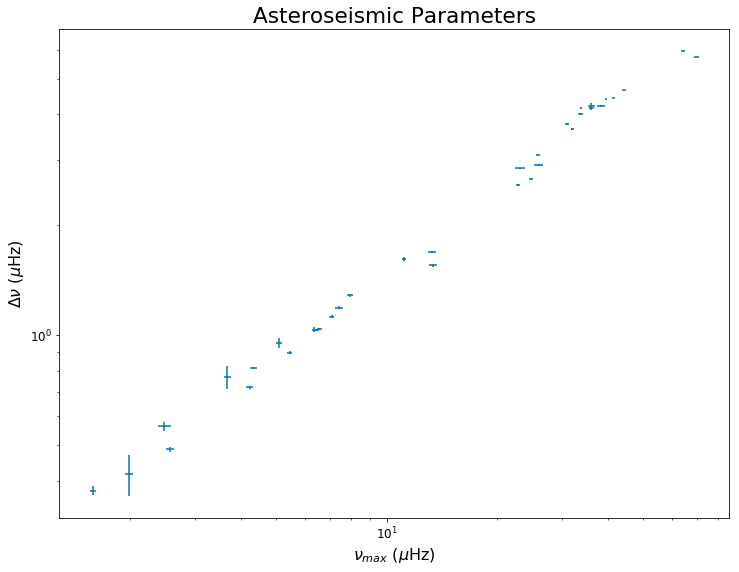

In [17]:
# the stars follow the expected numax-Dnu relation
plt.errorbar(seismic['Numax'],seismic['Dnu'],xerr=seismic['Numax_err'],yerr=seismic['Dnu_err'],linestyle='none')
plt.xlabel(r'$\nu_{max}$ ($\mu$Hz)')
plt.ylabel(r'$\Delta\nu$ ($\mu$Hz)')
plt.title('Asteroseismic Parameters')
plt.xscale('log')
plt.yscale('log')

### Which ones are missing?

In [18]:
badstars = ['BD+39_388','BD+43_306','HD_179959','HD_185351','HD_187217','HD_188639','HD_188875','HD_188629']
notes = ['No secure detection','Not consistent with RG pattern','Possible contamination',r'\citep{2017MNRAS.464.3713H}',
         'Possible contamination or binary',r'Too difficult to get a robust \Dnu',r'Too difficult to get a robust \Dnu',
         r'Too difficult to get a robust \Dnu']

notecol = [notes[j] if star in badstars else '' for j, star in enumerate(seismic['Star_ID'])]

In [19]:
np.sort(badstars)

array(['BD+39_388', 'BD+43_306', 'HD_179959', 'HD_185351', 'HD_187217',
       'HD_188629', 'HD_188639', 'HD_188875'], dtype='|S9')

In [20]:
for star in merged['Object']:
    if star[:9] not in seismic['Star_ID']:
        print star[:9]

BD+43_306
HD_179959
HD_185351
HD_187217
HD_188629
HD_188875


In [21]:
for star in seismic['Star_ID']:
    if star not in merged['Object'].astype('S9'):
        print star

BD+42_315
BD+48_290
HD_176209
HD_183354
HD_189636
HD_189750


## Read the main catalogue

In [56]:
fname_cat = '../data/catalogue.csv'
cat = Table.read(fname_cat,format='ascii')
cat.sort('kepmag')

In [23]:
cat

Name,SpType,[Fe/H],theta,Observed,Seasons,Teff,Log_G,E(B-V),g,r,J,kepmag,Edge_Dist,Notes,Collaborators,Interferometry?,TRES?
str10,str15,float64,float64,str29,int64,int64,float64,float64,float64,float64,float64,float64,int64,str84,str16,str3,str3
HD_185351,G9IIIbCN,0.16,1.156,LC:Q1-3 SC:Q16 under,4,--,--,--,6.091,5.176,3.654,5.034,59,RG: Retired A star,Hjorringgaard,--,Yes
HD_186155,F5II-III,0.3,0.57,LC:Q1 under,4,--,--,--,5.44,5.065,4.419,5.055,66,three sharp peaks,--,--,--
HD_175740,G8III,-0.1,1.035,unobserved,4,--,--,--,6.486,5.462,4.08,5.212,0,RG: suppressed l=1,"Tim W, Guy, Cleo",Yes,Yes
HD_184875,A2V,--,0.349,unobserved,4,--,--,--,5.399,5.337,5.128,5.403,0,Classical Pulsator,--,--,--
14_Cyg,B9III,0.08,0.267,unobserved,4,--,--,--,5.334,5.394,5.365,5.49,0,"contact binary, interesting ramp at low freq",--,--,--
HD_189178,B5V,--,0.236,unobserved,4,--,--,--,5.356,5.448,5.595,5.552,0,Classical Pulsator,--,--,--
HD_187372,M1III,--,2.693,unobserved,4,--,--,--,7.805,6.141,2.979,5.672,110,RG: low freq,--,--,--
HD_182694,G7IIIa,-0.01,0.771,LC:Q2 under,4,--,--,--,6.76,5.86,4.437,5.722,137,RG,Tim W,Yes,--
V380_Cyg,B1.1III+B2.5/3V,1.25,0.226,LC:Q11 SC:Q7 9 10 12-17 under,4,--,--,--,5.615,5.675,5.712,5.771,122,Eclipsing_binary,--,--,--


In [24]:
print 'Clump Candidates:',oxford_join([name.replace('_',' ') for name in cat[np.array(['clump' in thing for thing in list(cat['Notes'].data.data[:])])]['Name']])

Clump Candidates: HD 181069, HD 183354, HD 183124, HD 182692, and HD 180658


In [115]:
for l, ccat in enumerate([cat[:52],cat[52:]]):

    newtab = Table([Column([str(obj).replace('_',' ') for obj in ccat['Name']],name='Object')])

    newkeys = ['SpType','kepmag', 'Observed', 'Seasons','TRES?']
    names = [r'Spectral Type',r'$Kp$', r'Observed',r'Seasons','Spectroscopy']
    units = [r'(SIMBAD)', r'(mag)','','','']

    for k, key in enumerate(newkeys):
        col = ccat[key]
        if 'bs' in key:
            test = Column([entry.replace('under','') if 'under' in entry else 'unobserved' for entry in col],name=names[k])
        elif key != 'TRES?':
            test = Column(col.data,name=names[k])
        if key == 'TRES?':
            test = Column(['TRES' if newtab['Object'][j].replace(' ','_') in merged['Object'] else '--' for j,entry in enumerate(col)], name=names[k])
        newtab.add_column(test)
    
    latexdict = ascii.latex.latexdicts['AA'].copy()
    latexdict['tabletype']= 'table*'
    latexdict['units'] = dict(zip(names,units))
    if l == 0:
        caption = r'The full set of underobserved and unobserved stars for which new light curves have been produced in this smear catalogue.' 
        caption = caption+r'\label{all_stars}'
        newtab.write('../paper/all_stars.tex',format='latex',latexdict=latexdict,caption=caption+'\label{all_stars}',overwrite=True)
        print 'Written %s' % '../paper/all_stars.tex'
    else:
        latexdict['preamble'] = '\contcaption{The full set of underobserved and unobserved stars for which new light curves have been produced in this smear catalogue. \label{all_stars_cont}}'
        newtab.write('../paper/all_stars2.tex',format='latex',latexdict=latexdict,overwrite=True)
        print 'Written %s' % '../paper/all_stars2.tex'

Written ../paper/all_stars.tex
Written ../paper/all_stars2.tex


In [70]:
newtab['Object'][([entry.replace(' ','_') in merged['Object'] for entry in newtab['Object']])]

HD 182692
HD 178797
HD 188537
HD 181778
HD 180475
HD 188629
HD 226754
HD 178910
HD 181097
HD 180658
HD 182531


In [71]:
merged['Object'][([entry.replace('_',' ') not in newtab['Object'] for entry in merged['Object']])].astype('S10')

HD_174020
HD_174829
HD_175740
HD_175884
HD_179959
HD_180682
HD_181022
HD_181069
HD_181597
HD_182694
HD_183124


In [75]:
newtab.sort(r'$Kp$')
newtab['Object']

HD 184788
HD 184147
BD+42 3367
HD 177697
HD 182692
HD 178797
HD 184215
HD 188537
V546 Lyr
HD 176209
HD 174676


In [99]:
cat.pprint(max_lines=102)

   Name         SpType     [Fe/H] ...  Collaborators   Interferometry? TRES?
---------- --------------- ------ ... ---------------- --------------- -----
 HD_185351        G9IIIbCN   0.16 ...    Hjorringgaard              --   Yes
 HD_186155        F5II-III    0.3 ...               --              --    --
 HD_175740           G8III   -0.1 ... Tim W, Guy, Cleo             Yes   Yes
 HD_184875             A2V     -- ...               --              --    --
    14_Cyg           B9III   0.08 ...               --              --    --
 HD_189178             B5V     -- ...               --              --    --
 HD_187372           M1III     -- ...               --              --    --
 HD_182694          G7IIIa  -0.01 ...            Tim W             Yes    --
  V380_Cyg B1.1III+B2.5/3V   1.25 ...               --              --    --
 HD_186121           M2III     -- ...               --              --    --
 HD_189684           A5III     -- ...               --              --    --

In [103]:
cat[cat['Name']=='HD_174020']

Name,SpType,[Fe/H],theta,Observed,Seasons,Teff,Log_G,E(B-V),g,r,J,kepmag,Edge_Dist,Notes,Collaborators,Interferometry?,TRES?
str10,str15,float64,float64,str29,int64,int64,float64,float64,float64,float64,float64,float64,int64,str84,str16,str3,str3
HD_174020,K5,--,--,LC:Q2 6 10 14 under,4,--,--,--,8.749,7.187,4.893,6.753,17,RG,--,--,--
